# MOBIL模型仿真

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import random
dt=0.1#步长
Cn=0#换道次数
C=[]#换道信息记录
A_i=4#IDM模型参数
v_f=30#期望速度
δ=2#
l=6#默认车长
s_0=8#安全距离
s_1=0#IDM参数
T_i=1.1#IDM参数
b_i=4#
Δa=0.39#换道门槛
a_bias=0#换道平衡
b_safe=-4#换道对后车影响安全减速度

In [2]:
class Vehicle:#车辆定义
    def __init__(self,ID=0,LID=1,T=10,S=float("inf"),V=v_f,A=0,X=0,flag=0,stop=0,p=0.1):
        self.ID=ID#车辆ID
        self.LID=[LID for t in range(T)]#车辆所在车道ID
        self.FID=-1#跟驰前车ID
        self.BID=-1#被跟驰后车ID
        self.FCID=-1#换道后 前车ID
        self.BCID=-1#换道后 后车ID
        self.FFlag=0#跟驰检测
        self.CFlag=0#换道检测
        self.s=[S for t in range(T)]#车头间距数据储存
        self.v=[V for t in range(T)]#速度数据储存
        self.a=[A for t in range(T)]#加速度数据储存
        self.x=[X for t in range(T)]#位移数据储存
        self.flag=flag#是否在路段内
        self.stop=stop#是否停止
        self.p=p#利他因子

In [3]:
class Lane:#车道定义
    def __init__(self,ID=1,LL=1000,T=1*60*60,Iq=1000/3600,flag=1,dm=0):
        self.flag=flag#末端能否通行
        self.ID=ID#车道ID
        self.LL=LL#车道长度
        self.Iq=Iq#输入流量
        if self.flag!=0:
            self.VID=0#该车道下次到达的车辆ID
            self.Vehicles=[Vehicle(n,ID,T) for n in range(int(T*Iq))]#提前分配该车道预计到达车辆
        if self.flag==0:
            self.VID=1#起始车辆ID设置为1
            #初始位置和利他因子设置
            self.Vehicles=[Vehicle(ID=n,LID=ID,T=T,X=dm,p=0) for n in range(int(T*Iq))]
            #设置一辆常停车在路端
            self.Vehicles[0].stop=1
            self.Vehicles[0].flag=1
            self.Vehicles[0].x=[LL+dm for t in range(T)]

In [4]:
def IDM(s=s_0,v1=0,v0=0):#IDM模型求加速度
    if s-l<=0:#修改后的IDM，由于公式自带的平方项，当s减少到车长下时，负效应会消失，应控制使其大于车场
        s=6.01
    a=A_i*(1-math.pow((v1/v_f),δ)-math.pow(((Sit(v1,v0)-l)/(s-l)),2))
    return max(a,-6)#最大减速度

In [5]:
def Sit(v1=0,v0=0):#期望车距函数
    Sx=s_0+s_1*math.pow((v1/v_f),0.5)+T_i*v1+(v1*(v1-v0))/(2*math.pow(A_i*b_i,0.5))
    return Sx

In [6]:
#换道需求+安全换道
def DS(a0=0,a1=0,a2=0,ac2=0,s1c=s_0,s2c=s_0,sc2c=s_0,v0=0,vc0=0,v1=0,v2=0,vc2=0,p=1):
    a1c=IDM(s1c,v1,vc0)#换道后 本车的加速度
    a2c=IDM(s2c,v2,v0)#换道后 原后车的加速度
    ac2c=IDM(sc2c,vc2,v1)#换道后 后车的加速度
    D=a1c-a1+p*(a2c-a2+ac2c-ac2)
    if D>Δa+a_bias and ac2c>b_safe:
        return 1
    else:
        return 0

In [7]:
def Poisson(lam):#泊松近似，当步长足够小时与泊松无明显区别
    u = random.uniform(0,1)
    p = 2.718281828459045**(-lam)
    f = p
    if u < f:
        return 0
    else:
        return 1

In [8]:
def Simulation(ln=2,ll=1000,T=1*60*60,Iq=1000/3600):#仿真
    global Cn
    global C
    #初始化
    T=int(T/dt)
    #主路
    Lanes=[Lane(n+1,ll,T,Iq) for n in range(ln)]
    #匝道
    MLane=Lane(0,300,T,500/3600,0,7500)
    Lanes.insert(0,MLane)
    #路段内的车
    Vehicles=[MLane.Vehicles[0]]#先将匝道端部设想的停止车辆添加到路段中
    
    #开始仿真
    for t in range(T-1):
        
        #到达
        for L in Lanes:
            if Poisson(L.Iq*dt):
                if L.VID<T*L.Iq*dt:
                    V=L.Vehicles[L.VID]
                    V.flag=1
                    Vehicles.append(V)
                    L.VID+=1
                    
        #跟驰判断与匹配
        for V in Vehicles:
            if V.stop==0:
                if V.LID[t]==0 and V.ID!=0 and 1070>V.x[t]>=1030 and t%10==0:
                    print(V.ID,V.x[t],V.v[t],V.a[t],V.FID,Vehicles[0].LID[t])
                V.FFlag=0
                for F in Vehicles:
                    if F.LID[t]==V.LID[t] and F.x[t]>V.x[t]:
                        V.FFlag=1
                        if F.x[t]-V.x[t]<V.s[t]:
                            V.FID=Vehicles.index(F)
                            V.s[t]=F.x[t]-V.x[t]
                if V.FFlag==0:
                    V.FID=-1
        
        #跟驰
        for V in Vehicles:
            if V.stop==0:
                if V.FFlag==1:
                    V.v[t+1]=max(V.v[t]+V.a[t]*dt,0)
                    V.x[t+1]=V.x[t]+0.5*(V.v[t]+V.v[t+1])*dt
                    V.a[t+1]=IDM(V.s[t],V.v[t],Vehicles[V.FID].v[t])
                else:
                    V.v[t+1]=max(V.v[t]+V.a[t]*dt,0)
                    V.x[t+1]=V.x[t]+0.5*(V.v[t]+V.v[t+1])*dt
                    V.a[t+1]=IDM(float("inf"),V.v[t],v_f)
        
        #后车查询
        for V in Vehicles:
            for B in Vehicles:
                if B.FID==Vehicles.index(V):
                    V.BID=Vehicles.index(B)
                    break
            V.BID=-1
        
        #相邻车道前车判断与匹配
        for V in Vehicles:
            if V.stop==0:
                ts=float("inf")
                V.FCID=-1
                for F in Vehicles:
                    if ((F.LID[t]==1 and V.LID[t]==0) or (F.LID[t]==2 and V.LID[t]==1) or (F.LID[t]==1 and V.LID[t]==2)) and 0<F.x[t]-V.x[t]<ts:
                        V.FCID=Vehicles.index(F)
                        ts=F.x[t]-V.x[t]
        
        #相邻车道后车判断与匹配
        for V in Vehicles:
            if V.stop==0:
                ts=float("inf")
                V.BCID=-1
                for B in Vehicles:
                    if ((B.LID[t]==1 and V.LID[t]==0) or (B.LID[t]==2 and V.LID[t]==1) or (B.LID[t]==1 and V.LID[t]==2)) and 0<V.x[t]-B.x[t]<ts:
                        V.BCID=Vehicles.index(B)
                        ts=V.x[t]-B.x[t]
        
        #换道判断
        for V in Vehicles:
            if V.stop==0:
                a0=0;a1=V.a[t];a2=0;ac2=0;s1c=float("inf");s2c=float("inf");sc2c=float("inf");v0=0;vc0=0;v1=V.v[t];v2=0;vc2=0;p=V.p
                if V.FID>=0:
                    F=Vehicles[V.FID]
                    a0=F.a[t]
                    v0=F.v[t]
                if V.BID>=0:
                    B=Vehicles[V.BID]
                    a2=B.a[t]
                    v2=B.v[t]
                    if V.FID>=0:
                        s2c=Vehicles[V.FID].x[t]-B.x[t]
                if V.FCID>=0:
                    FC=Vehicles[V.FCID]
                    s1c=FC.x[t]-V.x[t]
                    vc0=FC.v[t]
                if V.BCID>=0:
                    BC=Vehicles[V.BCID]
                    ac2=BC.a[t]
                    vc2=BC.v[t]
                    sc2c=V.x[t]-BC.x[t]
                if DS(a0,a1,a2,ac2,s1c,s2c,sc2c,v0,vc0,v1,v2,vc2,p):
                    if V.LID[t]==1:
                        V.CFlag=2
                    else:
                        V.CFlag=1
                else:
                    V.CFlag=0
        #换道
        for V in Vehicles:
            if V.stop==0:
                while V.FID!=-1 and V.CFlag!=0:#检测前80m内有无换道，有则推迟换道（推迟到下一个步长，保证换道判断同步性的同时，减少一队车辆同时换道的情况）
                    if Vehicles[V.FID].x[t]-V.x[t]>80:
                        break
                    if Vehicles[V.FID].CFlag!=0:
                        V.CFlag=0
                        break
                    V.FID=Vehicles[V.FID].FID
                if V.CFlag!=0 and 0<V.x[t]<ll and (V.FID<0 or Vehicles[V.FID].CFlag==0):
                    if t>300/dt:#前5min预热，使车辆散布到路段
                        Cn+=1
                        C.append((V.x[t],V.LID[t]))
                    for tt in range(t,T-1):#换道成功后，修改该车所在车道
                        V.LID[tt]=V.CFlag
        
        if V.LID[t]==0 and 7800<=V.x[t]<=ll and V.stop==0:
            print(V.LID[0],V.ID,V.x[t],V.v[t],V.a[t],V.x[t+1],V.FID)
        
        #出界处理
        for V in Vehicles:
            if V.x[t]>ll or V.x[t]<0:#将位移大于路段长度的车辆从路段中剔除
                V.flag=0
                for tt in range(t,T-1):
                    V.LID[tt]=V.LID[0]
                del Vehicles[Vehicles.index(V)]
    
    print("ok")
    return Lanes

In [9]:
def Visual(Results,ll,ln,T):#可视化
    x=[100*int(i/3) for i in range(int(3*ll/100+3))]
    y=[i%3 for i in range(int(3*ll/100+3))]
    #print(y)
    s=[0 for i in range(int(3*ll/100+3))]
    for c in C:
        if 0<=c[0]<=ll:
            s[3*int(c[0]/100)+c[1]]+=1
        #if c[1]!=1:
            #print(c[0],c[1],3*int(c[0]/100)+c[1],(3*int(c[0]/100)+c[1])%3)
    plt.rcParams["font.family"] = 'Arial Unicode MS'
    plt.figure(figsize=(15,1))
    plt.title("换道分布")
    plt.xlim([0,10000])
    plt.scatter(x,y,s)
    '''fig=plt.figure(figsize=(15,1))
    plt.title("车道-位移")
    plt.xlim([0,10000])
    ims=[]
    for t in range(int(T/dt)-1):
        if 3600<t<5600 and t%10==0:
            x=[0,0,0]
            y=[0,0,0]
            for i in range(3):
                x[i]=[V.x[t] for V in Results[i].Vehicles]
                y[i]=[V.LID[t] for V in Results[i].Vehicles]
            X=x[0]+x[1]+x[2]
            Y=y[0]+y[1]+y[2]
            im=plt.scatter(X,Y,c='k').findobj()
            ims.append(im)
    animation = ani.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
    animation.save("test.gif",writer='pillow')'''

In [10]:
ln=2
ll=10*1000
T=0.2*60*60
Iq=1000/3600
Results=Simulation(ln,ll,T,Iq)

ok


In [11]:
print("换道次数:",int(Cn*dt),"每秒换道:",Cn*dt/(T-300),"换道比例:",Cn*dt/(Results[0].VID+Results[1].VID+Results[2].VID))

换道次数: 618 每秒换道: 1.4733333333333336 换道比例: 1.3165957446808512


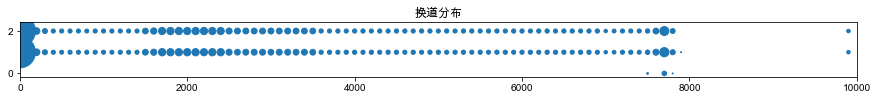

In [12]:
Visual(Results,ll,ln,T)

> Sofarja@outlook.com
>
> ---
>
> 21018116
>
> 郭艺铧
>
> 交通工程